# Twitter Airline Sentiment Analysis 
## By Sharon Agai

### Utilities

#### Google Colab utilities

In [1]:
# for google colab

!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
                    
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
!pip install fastai

# gpu check
gpu = GPUs[0]
def printm():
  process = psutil.Process(os.getpid())
  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

printm()

# if ram is low 
# !pkill -9 -f ipykernel_launcher
# and try again

Gen RAM Free: 11.5 GB  | Proc size: 142.9 MB
GPU RAM Free: 9882MB | Used: 1559MB | Util  14% | Total 11441MB


In [2]:
from google.colab import files
uploaded = files.upload()

Saving Tweets.csv to Tweets (1).csv


#### Python utilities

In [3]:
from datetime import datetime
from fastai import *
from fastai.callbacks import *
from fastai.text import *
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords 
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from torchtext import vocab

nltk.download('stopwords')

sns.set(style="whitegrid")
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
raw_tweets = pd.read_csv('Tweets.csv', encoding='latin-1')
raw_tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


### Data Visualization (and very basic cleaning)

#### Basic cleaning
What does the data look like? Is there anything I know I should drop because it has many NaN values or I will not be using for sentiment analysis? 

In [5]:
# percent of NaNs in each columns
print(((len(raw_tweets)-raw_tweets.count()) / len(raw_tweets))*100)

raw_tweets = raw_tweets.drop(['airline_sentiment_gold', 'negativereason_gold', 'tweet_coord'], axis=1)
print(raw_tweets.columns)

# duplicates
raw_tweets = raw_tweets.drop_duplicates(subset=['tweet_id', 'text'])

# drop columns I am unlikely to use 
raw_tweets = raw_tweets.drop(['airline_sentiment_confidence', 'negativereason_confidence', 'tweet_created',
                             'tweet_location', 'user_timezone'], axis=1)

raw_tweets.info()

tweet_id                         0.000000
airline_sentiment                0.000000
airline_sentiment_confidence     0.000000
negativereason                  37.308743
negativereason_confidence       28.128415
airline                          0.000000
airline_sentiment_gold          99.726776
name                             0.000000
negativereason_gold             99.781421
retweet_count                    0.000000
text                             0.000000
tweet_coord                     93.039617
tweet_created                    0.000000
tweet_location                  32.329235
user_timezone                   32.923497
dtype: float64
Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline', 'name',
       'retweet_count', 'text', 'tweet_created', 'tweet_location',
       'user_timezone'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Int64Index: 14485 entries, 0 to 14639
Data columns (total 

#### Visualization

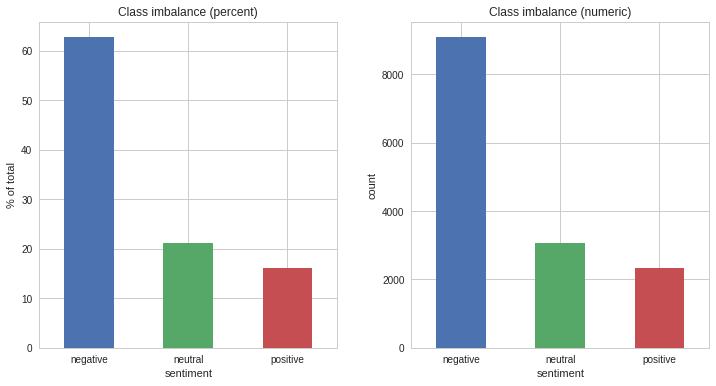

In [6]:
# Class imbalance

negatives = raw_tweets[(raw_tweets['airline_sentiment'] == 'negative')]
neutrals = raw_tweets[(raw_tweets['airline_sentiment'] == 'neutral')]
positives = raw_tweets[(raw_tweets['airline_sentiment'] == 'positive')]

imb_percent = (raw_tweets['airline_sentiment'].value_counts()/len(raw_tweets))*100
imb_num = raw_tweets['airline_sentiment'].value_counts()


fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
plt.subplots_adjust(wspace=0.25)

imb_percent.plot(kind='bar', ax=ax1)
ax1.set_title('Class imbalance (percent)')
ax1.set_xlabel('sentiment')
ax1.tick_params(axis='x', rotation=360)
ax1.set_ylabel('% of total')

imb_num.plot(kind='bar', ax=ax2)
ax2.set_title('Class imbalance (numeric)')
ax2.set_xlabel('sentiment')
ax2.tick_params(axis='x', rotation=360)
ax2.set_ylabel('count')

plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


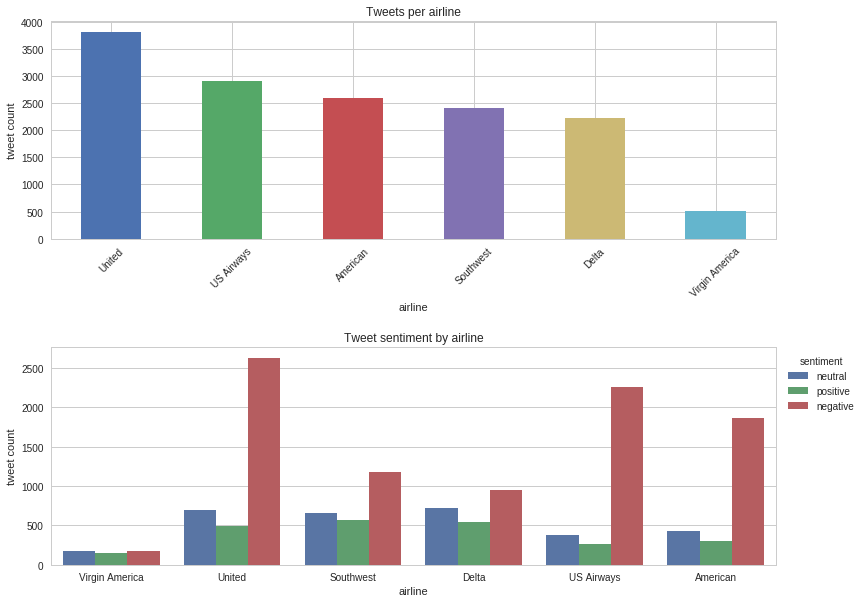

In [7]:
# Splitting up the tweets and tweet_sentiment by airline 

fig,(ax1,ax2) = plt.subplots(2,1,figsize=(13,10))
plt.subplots_adjust(hspace=0.5)

airline_counts = raw_tweets['airline'].value_counts()
airline_counts.plot(kind='bar', ax=ax1)
ax1.set_title('Tweets per airline')
ax1.tick_params(axis='x', rotation=45)
ax1.set_xlabel('airline')
ax1.set_ylabel('tweet count')

counts_by_airline = sns.countplot(x='airline', hue='airline_sentiment', data=raw_tweets, ax=ax2)
ax2.set_title('Tweet sentiment by airline')
ax2.set_ylabel('tweet count')
ax2.legend(bbox_to_anchor=(1.12, 1), title='sentiment')

plt.show()

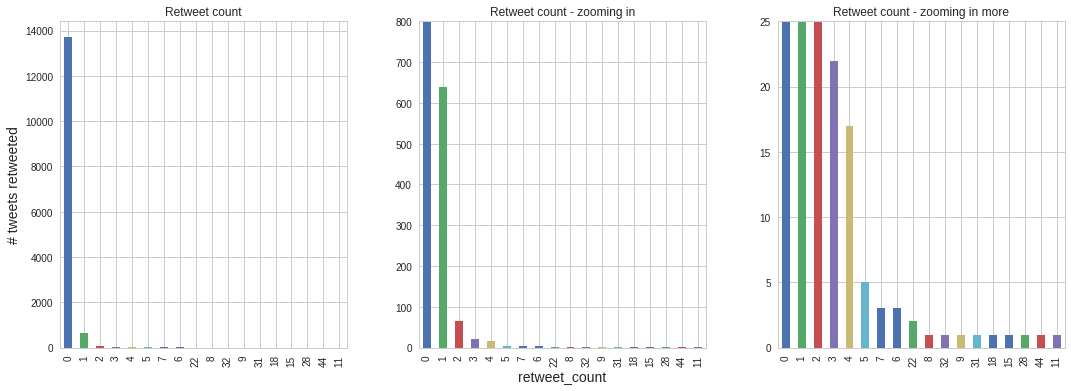

In [8]:
# Are any tweets especially retweeted? 

fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(18,6))
plt.subplots_adjust(wspace=0.25)

retweets = raw_tweets['retweet_count'].value_counts()
retweets.plot(kind='bar', ax=ax1)
ax1.set_title('Retweet count')
ax1.set_ylabel('# tweets retweeted', fontsize=14)

retweets.plot(kind='bar', ax=ax2)
ax2.set_title('Retweet count - zooming in')
ax2.set_xlabel('retweet_count', fontsize=14)
ax2.set_ylim(0,800)

retweets.plot(kind='bar', ax=ax3)
ax3.set_title('Retweet count - zooming in more')
ax3.set_ylim(0,25)

plt.show()

Most of the tweets are not retweeted, or only retweeted by a couple users. The most popular tweet was retweeted 44 times! Let's see what it was.

In [9]:
most_retweeted = np.argmax(raw_tweets['retweet_count'])
print('Retweets:', raw_tweets.iloc[most_retweeted]['retweet_count'])
print('Index of most retweeted tweet:', most_retweeted)
print('Tweet:', raw_tweets.iloc[most_retweeted]['text'])

Retweets: 44
Index of most retweeted tweet: 11596
Tweet: @USAirways 5 hr flight delay and a delay when we land . Is that even real life ? Get me off this plane , I wanna go home ð ð ð  (3 heel clicks)


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:56: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


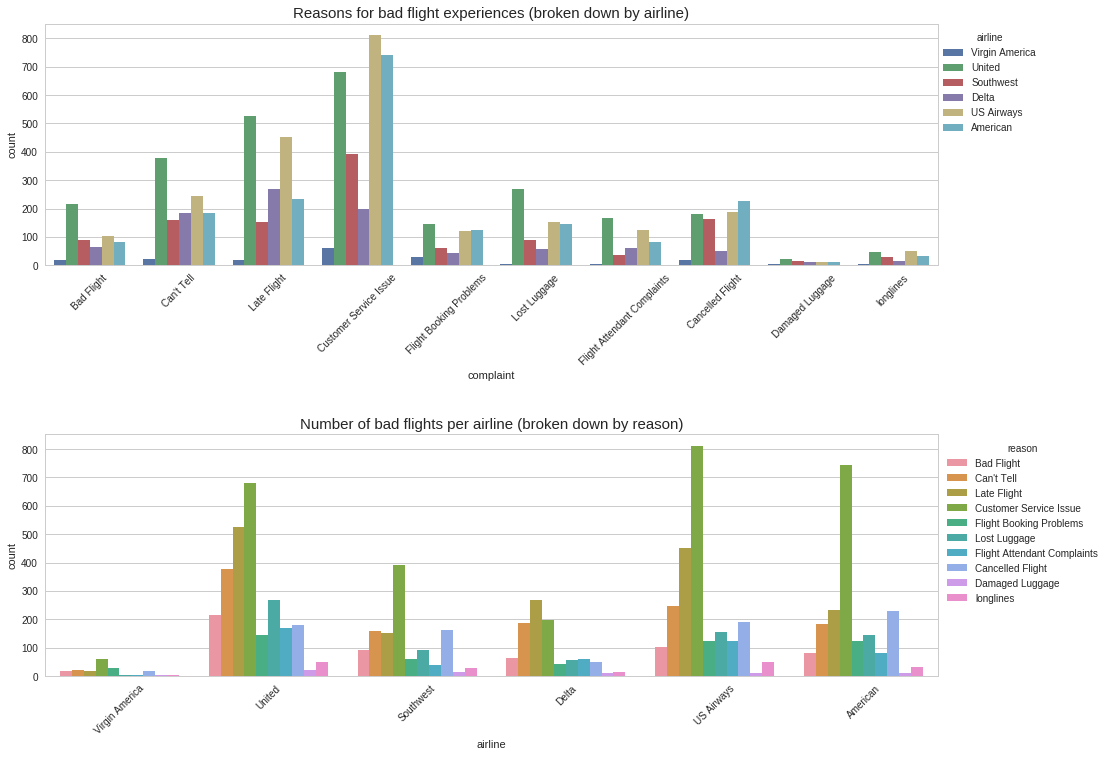

In [10]:
# Why are people having bad flights? 

fig,(ax1,ax2) = plt.subplots(2,1,figsize=(16,12))
plt.subplots_adjust(hspace=0.7)

g1 = sns.countplot(x='negativereason', hue='airline', data=negatives, ax=ax1)
g1.set_title('Reasons for bad flight experiences (broken down by airline)', fontsize='15')
g1.set_xlabel('complaint')
g1.tick_params(axis='x', rotation=45)
g1.legend(bbox_to_anchor=(1.12, 1), title='airline')

g2 = sns.countplot(x='airline', hue='negativereason', data=negatives, ax=ax2)
g2.set_title('Number of bad flights per airline (broken down by reason)', fontsize='15')
g2.tick_params(axis='x', rotation=45)
g2.legend(bbox_to_anchor=(1, 1), title='reason')

plt.show()

In [11]:
# Check that the tweets parse properly 
# SOURCE: https://towardsdatascience.com/yet-another-twitter-sentiment-analysis-part-1-tackling-class-imbalance-4d7a7f717d44

token_length = [len(x.split(" ")) for x in raw_tweets.text]
print('Longest tweet:', max(token_length), 'tokens') 
print('Index of longest tweet:', token_length[max(token_length)])
print(raw_tweets.text[16])

Longest tweet: 36 tokens
Index of longest tweet: 16
@VirginAmerica So excited for my first cross country flight LAX to MCO I've heard nothing but great things about Virgin America. #29DaysToGo


### Cleaning and preprocessing

#### Cleaning

I experimented with several different cleaning functions, especially those relating to removing cases and tokenization (even though the fastai databunch module will do this for us). I chose the cleaning functions below because they balance normalizing the text with "overcleaning" it and losing information that could be helpful to fitting the model. 

In [0]:
# Removing handles 
# SOURCE: https://www.analyticsvidhya.com/blog/2018/07/hands-on-sentiment-analysis-dataset-python/

def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt 

raw_tweets['tidy_tweet'] = np.vectorize(remove_pattern)(raw_tweets['text'], "@[\w]*")

In [0]:
# Removing non-ASCII characters 

raw_tweets['tidy_tweet'] = raw_tweets['tidy_tweet'].str.encode('ascii', 'ignore').str.decode('utf-8', 'ignore')

In [0]:
# Replace commonly seen 'weird' characters that are left
# SOURCE: # https://nbviewer.jupyter.org/github/fastai/fastai/blob/master/courses/dl2/imdb.ipynb

re1 = re.compile(r'  +')
def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

raw_tweets['tidy_tweet'] = raw_tweets['tidy_tweet'].apply(fixup).values

In [0]:
# Label encoding for sentiment

labelencoder = LabelEncoder()
raw_tweets['airline_sentiment'] = labelencoder.fit_transform(raw_tweets['airline_sentiment'])

Note: I chose to label encode instead of one hot encode because it retains the relationship between negative, neutral, and positive more than one hot encoding does

#### Preparing the data for modeling

In [16]:
texts = raw_tweets['tidy_tweet']
sents = raw_tweets['airline_sentiment'] 
tweets_df = pd.concat([sents,texts], axis=1)
tweets_df.head()

,airline_sentiment,tidy_tweet
0,1,What said.
1,2,plus you've added commercials to the experien...
2,1,I didn't today... Must mean I need to take an...
3,0,"it's really aggressive to blast obnoxious ""en..."
4,0,and it's a really big bad thing about it


In [0]:
# Creating data bunch for language model using the data block API

data_lm = (TextList.from_df(tweets_df, cols='tidy_tweet')
            .random_split_by_pct(valid_pct=0.1)
            .label_for_lm()           
            .databunch(bs=48))

In [18]:
data_lm.show_batch()

idx,text
0,"nearly every time i fly xxup vx this xxunk xxunk wo nt go away :) xxbos xxmaj really missed a prime opportunity for xxmaj men xxmaj without xxmaj xxunk xxunk , there . https : / / t.co / xxunk xxbos xxmaj well , i xxunk xxup now i xxup do ! xxup xxunk xxbos it was amazing , and arrived an hour early . xxmaj you 're too good"
1,luggage . xxbos xxmaj xxunk xxmaj xxunk gave a # xxunk performance of the safety xxunk this evening on xxup xxunk # xxup xxunk # xxunk # xxunk xxbos xxmaj thanks ! xxbos thanks for taking care of on her flight ! ! # xxunk # travel xxbos xxmaj thanks for the lovely soft views ! # travel # xxup san to # xxup sfo http : / / t.co
2,"no but is there a way to get a cheaper airfare ticket if the flight is leaving in a few hours ? xxbos can someone please explain the process of of what happens to property found on a plane after passengers leave at xxmaj heathrow ? xxbos not able to xxup dm you my confirmation number xxbos i 've sent the message , let me know if you got it"
3,"i 'm used to . xxmaj opened the app to find flight changed . xxbos that is not in line with your responses here . xxmaj and now i 'm waiting until tomorrow morning because all the flights are overbooked . xxbos i took the exact same aircraft in to xxup lax 3 days ago . xxmaj it fit , no problem . xxmaj the agent today told some nonsense"
4,"giving up and trying another airline ! ! ! xxbos i got email update but still no xxup eta . xxmaj more communication / details , apology + info on compensation rights would go a long way xxbos xxmaj late xxmaj flight crew into # btv last nite delayed todays flt . xxmaj will miss connection to # cun . xxmaj why do i have to play for hotel tonight"


In [0]:
# Creating data bunch for classifier using the data block API

data_clas = (TextList.from_df(tweets_df, cols='tidy_tweet', vocab=data_lm.vocab)
                   .random_split_by_pct(valid_pct=0.1)
                   .label_from_df(cols='airline_sentiment')
                   .databunch(bs=48))

In [20]:
data_clas.show_batch()

text,target
xxbos xxmaj hi have a question re future xxmaj flight xxmaj booking xxmaj problems . xxup dub - xxup jac 29 / 9 xxup jac - xxup lax 8 / 10 xxup lax - xxup dub 13 / 10 . i 'm * xxup xxunk xxmaj what is checked bag allowance for xxup jac - xxup lax ?,1
xxbos xxup xxunk u xxup us xxup airways xxup with xxup yo xxup shitty xxup chicken xxup xxunk xxup sandwich xxup that xxup so xxup xxunk xxup and u xxup xxunk xxup make xxup me xxup wait xxup in a 6 xxup hr xxup layover xxup xxunk u xxup and,0
"xxbos i had to travel to xxmaj savannah , xxup xxunk , once again , on an airline i do n't "" xxmaj luv "" . xxmaj when r u going to fly me to xxmaj savannah ? xxmaj xxunk xxrep 4 e ase xxrep 4 !",1
xxbos i xxunk from xxup xxunk xxup xxunk feb 17 . the xxup ac on my sit ( xxup xxunk ) was xxup on all night . i complaint to xxup fa who never gave me a real answer . xxmaj help !,0
xxbos why xxmaj cancelled xxmaj flight # xxunk on 6 / 25 & & 6 / 28 ? xxmaj flights now 4 hrs longer & & have layovers . xxmaj too xxmaj late xxmaj flight to find a xxunk priced alternative .,0


### Importing ULMfit and tuning it to our dataset

#### Initializing model

In [0]:
# learn.destroy()
learn = language_model_learner(data_lm, arch=AWD_LSTM, drop_mult=0.7, callback_fns=ShowGraph)

**Reasoning:** 
* Dropout - my dataset is quite small, so right off the bat I knew I would need dropout to decrease noise and prevent overfitting. I experimented with different values (0.3, 0.5, 0.7) and ultimately chose 0.7. 
* Considered early stopping, but even having patience=1 created an overfitting problem so I used it to get a general idea of how many cycles to train for, but ultimately removed it.


In [0]:
# Addressing class imbalance by changing the weight of each class
# (i.e. the frequency of being seen)
# SOURCE: https://forums.fast.ai/t/correcting-class-imbalance-for-nlp/22152

labelcounts = tweets_df.groupby(['airline_sentiment']).size()
label_sum = len(tweets_df['airline_sentiment'])
weights_balance = [(1-count/label_sum) for count in labelcounts]
loss_weights = torch.FloatTensor(weights_balance).cuda()
learn.crit = partial(F.cross_entropy, weight=loss_weights)

#### Finetuning
**In short, I decided on a starting point using helper functions (like lr_find) and other people's experiences finetuning ULMfit models and made adjustments using training results.**
* Gradual unfreezing - best practice for ULMfit tuning
* Discriminative layer tuning - best practice for ULMfit tuning
* Momentum - weighting gradient descent to make convergence happen more quickly (and as a result help prevent overfitting)
* Weight decay - keeping overfitting in check


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-02


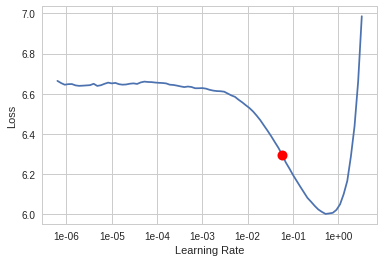

In [23]:
# Optimizing the learning rate - a starting point

learn.freeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,time
1,4.343239,3.887815,0.271875,00:34
2,3.836252,3.724718,0.289970,00:34


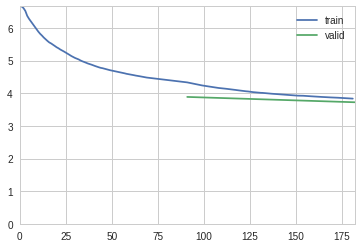

epoch,train_loss,valid_loss,accuracy,time
1,3.657377,3.720997,0.290863,00:28


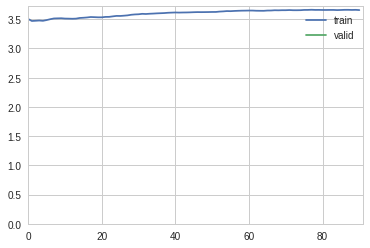

epoch,train_loss,valid_loss,accuracy,time
1,3.598732,3.718417,0.292381,00:32


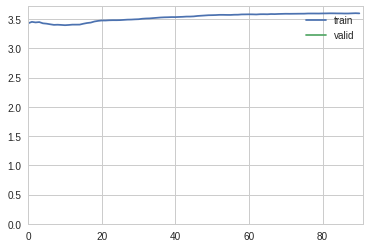

epoch,train_loss,valid_loss,accuracy,time
1,3.421288,3.726572,0.291726,00:34


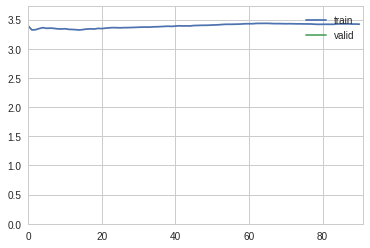

In [24]:
# Finetuning via gradual unfreezing and discriminative layer tuning 

learn.unfreeze()
learn.fit_one_cycle(2, slice(5e-2/(2.6**4), 5e-2), moms = (0.8,0.7), wd=1e-2)
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(3e-2/(2.6**4), 3e-2), moms = (0.8,0.7), wd=1e-2)
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(3e-2/(2.6**4), 3e-2), moms = (0.8,0.7), wd=1e-2)
learn.unfreeze()
learn.fit_one_cycle(1, slice(2e-2/(2.6**4), 2e-2), moms = (0.8,0.7), wd=1e-2)

In [0]:
# Saving the fine tuned language model 

learn.freeze()
learn.save('fine_tuned_lm')
learn.save_encoder('fine_tuned_lm_enc')

In [26]:
# Does this predicted tweet sort-of make sense? (yes!)

learn.predict('My flight last week was ', 15)

'My flight last week was  delayed , so no one could help though ! " on plane from PHX'

### Classifier creation and tuning

#### Initializing the classifier

In [0]:
# learn.destroy()
learn = text_classifier_learner(data_clas, arch=AWD_LSTM, drop_mult=0.7, callback_fns=ShowGraph)
learn.load_encoder('fine_tuned_lm_enc')
learn.clip=0.3

I decided to use gradient clipping because I noticed highly unstable error rates. Even with clip=0.3, my model is still slightly unstable. However, I found that increasing gradient clipping more than that caused my model to converge too quickly. 

In [0]:
# Addressing class imbalance 
# SOURCE: https://forums.fast.ai/t/correcting-class-imbalance-for-nlp/22152

labelcounts = tweets_df.groupby(['airline_sentiment']).size()
label_sum = len(tweets_df['airline_sentiment'])
weights_balance = [(1-count/label_sum) for count in labelcounts]
loss_weights = torch.FloatTensor(weights_balance).cuda()
learn.crit = partial(F.cross_entropy, weight=loss_weights)

#### Finetuning

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.20E-01


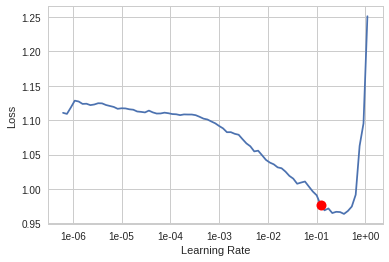

In [29]:
# Optimizing the learning rate - a starting point

learn.freeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,time
1,0.681739,0.493606,0.803177,00:47
2,0.602991,0.484807,0.801105,00:46
3,0.590077,0.514070,0.796961,00:46
4,0.545599,0.439957,0.836326,00:48
5,0.499461,0.425354,0.839779,00:46
6,0.455613,0.417327,0.841851,00:47
7,0.423668,0.414224,0.834945,00:46


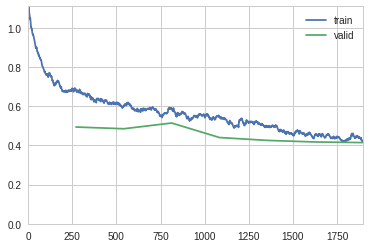

epoch,train_loss,valid_loss,accuracy,time
1,0.461662,0.421901,0.845994,00:21
2,0.422008,0.410320,0.841160,00:22


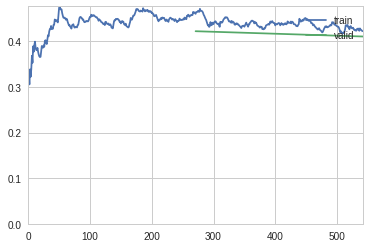

epoch,train_loss,valid_loss,accuracy,time
1,0.478298,0.464884,0.819751,00:36
2,0.433969,0.423077,0.839088,00:37


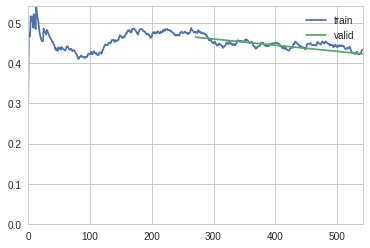

epoch,train_loss,valid_loss,accuracy,time
1,0.443928,0.455072,0.839779,00:48


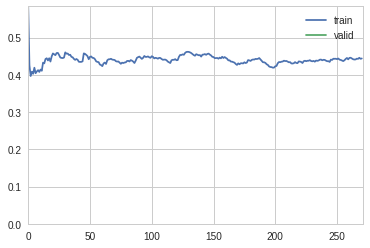

In [30]:
# Fine tuning

learn.unfreeze()
learn.fit_one_cycle(7, slice(2.5e-2/(2.6**4), 2.5e-2), moms = (0.8,0.7), wd=1e-2)
learn.freeze_to(-2)
learn.fit_one_cycle(2, slice(2e-2/(2.6**4), 2e-2), moms = (0.8,0.7), wd=1e-2)
learn.freeze_to(-3)
learn.fit_one_cycle(2, slice(2e-2/(2.6**4), 2e-2), moms = (0.8,0.7), wd=1e-2)
learn.unfreeze()
learn.fit_one_cycle(1, slice(1.5e-2/(2.6**4), 1.5e-2), moms = (0.8,0.7), wd=1e-2)

In [0]:
learn.save_encoder('fine_tuned_clas')

### Results

In [0]:
learn.load_encoder('fine_tuned_clas')

#### Cross-validation and extracting predictions

In [33]:
# Cross validation

val = learn.validate(learn.data.valid_dl, metrics=[accuracy])
print('Cross validation loss:', val[0])
print('Cross validation accuracy:', float(val[1]*100), '%')

Cross validation loss: 0.4550722
Cross validation accuracy: 83.9779052734375 %


In [34]:
# Getting validation predictions so we can explore our results more in-depth

y_pred, y_true = learn.get_preds(ds_type=DatasetType.Valid)
y_pred = np.array(np.argmax(y_pred, axis=1))
y_true = np.array(y_true)

print(y_pred)
print(y_true)

[1 0 1 0 ... 0 1 2 1]
[1 0 0 0 ... 1 1 2 1]


#### Performance metrics and future work

In [35]:
# Classification report
# SOURCE: https://blog.infegy.com/understanding-sentiment-analysis-and-sentiment-accuracy

class_rep = classification_report(y_true, y_pred, target_names=['negative', 'neutral', 'positive'])
print(class_rep)

              precision    recall  f1-score   support

    negative       0.87      0.93      0.90       920
     neutral       0.73      0.63      0.67       305
    positive       0.85      0.77      0.81       223

   micro avg       0.84      0.84      0.84      1448
   macro avg       0.82      0.77      0.79      1448
weighted avg       0.84      0.84      0.84      1448



The metric I want to focus on here is the F1 score, but I used a classification report to see precision and recall as well because they contribute to F1 score. F1 score is a better representation of the classifier's performance than accuracy alone because the classes are imbalanced, and F1 score accounts for this by considering recall. 

*  Immediately, we can see that the model was most successful in understanding the negative class - high precision and recall indicates that there weren't many false positives (i.e. predicting neutral or positive, actually negative) or false negatives (i.e. predicting negative, actually neutral or positive). Although we addressed class imbalance using weights, the model still saw a greater variety of negative sentiment samples. I would like to address this in future work by implementing another oversampling technique, such as SMOTE. 
* The positive class also exhibited adequate performance. Although both precision and recall for this class are lower than I would like, they are similar (and similar to the F1 score they produce). This means I probably need to train my model more in future work. Maybe I could find more data or create more using SMOTE oversampling, which would allow me to train my model for longer without overfitting. 
* The neutral class is the most interesting, as its performance is the most inconsistent. For the most part, the model was able to get an idea of which tweets DO belong in the neutral class - precision is nearly on par with the posititve class. However, it is less able to determine which tweets do NOT belong in the neutral class. This shows that the model isn't fully able to detect the sentiment of every tweet - some tweets' sentiment is not detected by the model, and so it is classified as neutral. I think I should train my model more, as described above. Additionally, I will continue to experiment with data cleaning for tweets, including which information to keep/replace (as described in Cleaning and Preprocessing --> Cleaning) and different tokenization and numericalization strategies. 

Lastly, the micro, macro, and weighted averages confirm that the weight adjustments I made did indeed address class imbalance. 





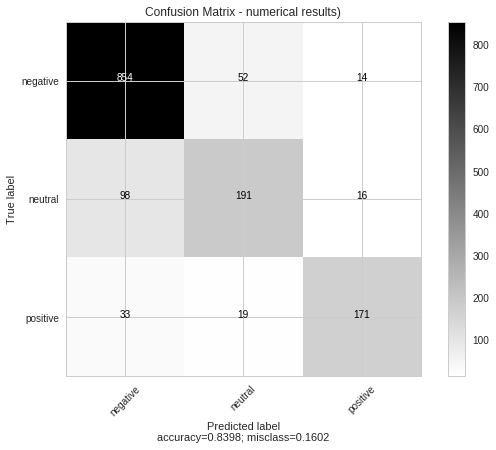

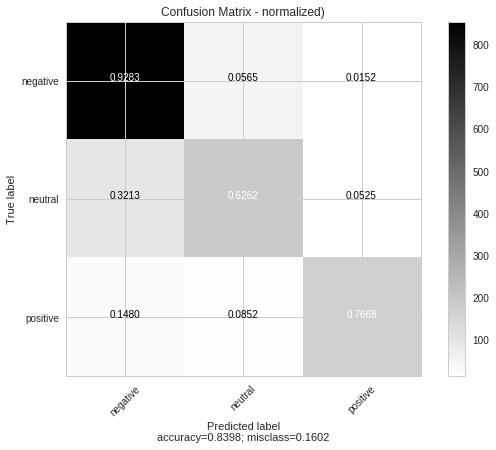

In [36]:
# Creating and plotting the confusion matrix
# SOURCE: https://www.kaggle.com/grfiv4/plot-a-confusion-matrix

cm = confusion_matrix(y_true, y_pred)

def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
  accuracy = np.trace(cm) / float(np.sum(cm))
  misclass = 1 - accuracy
  if cmap is None:
      cmap = plt.get_cmap('Blues')
  plt.figure(figsize=(8, 6))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  if target_names is not None:
      tick_marks = np.arange(len(target_names))
      plt.xticks(tick_marks, target_names, rotation=45)
      plt.yticks(tick_marks, target_names)
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  thresh = cm.max() / 1.5 if normalize else cm.max() / 2
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      if normalize:
          plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                   horizontalalignment="center",
                   color="white" if cm[i, j] > thresh else "black")
      else:
          plt.text(j, i, "{:,}".format(cm[i, j]),
                   horizontalalignment="center",
                   color="white" if cm[i, j] > thresh else "black")
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
  plt.show()
    
    
plot_confusion_matrix(cm=cm, target_names=['negative', 'neutral', 'positive'], 
                      title='Confusion Matrix - numerical results)', cmap='gist_yarg', normalize=False)
plot_confusion_matrix(cm=cm, target_names=['negative', 'neutral', 'positive'], 
                      title='Confusion Matrix - normalized)', cmap='gist_yarg', normalize=True)

These confusion matrices are consistent with the classification report above. Interestingly, the model had the most problems predicting neutral tweets as negative. I think the next steps will be to change the way I correct my class imbalance. Maybe if I gave the model a greater variety of neutral tweets, it would be more likely to recognize their nuances, as opposed to negative tweets. 